# Joining our Data Sets together
### Importing our R package

In [2]:
install.packages("remotes")
remotes::install_github("chenthih/nzmentalquake")
library(tidyverse)


Installing package into ‘/home/sekiro/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)




lifecycle (1.0.0 -> 1.0.1) [CRAN]
pillar    (1.6.2 -> 1.6.3) [CRAN]
tibble    (3.1.4 -> 3.1.5) [CRAN]


Installing 3 packages: lifecycle, pillar, tibble

Installing packages into ‘/home/sekiro/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



✔  checking for file ‘/tmp/RtmpJ1Cax3/remotes2f079260379/chenthih-nzmentalquake-a1b9536/DESCRIPTION’
─  preparing ‘nzmentalquake’:
✔  checking DESCRIPTION meta-information
─  checking for LF line-endings in source and make files and shell scripts
─  checking for empty or unneeded directories
─  looking to see if a ‘data/datalist’ file should be added
─  building ‘nzmentalquake_0.0.0.9000.tar.gz’
   


Installing package into ‘/home/sekiro/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



In [3]:
eq_df <- nzmentalquake::earthquake_dataset
eq_summary_df <- nzmentalquake::earthquake_summary_dataset
mh_df <- read_csv('FINAL_mental_health_by_city.csv', show_col_types = FALSE) %>% select(-1) #nzmentalquake::mental_health_dataset
pop_df <- read_csv('FINAL_population_by_city.csv', show_col_types = FALSE) %>% select(-1)#nzmentalquake::population_dataset

New names:
* `` -> ...1

New names:
* `` -> ...1



In [4]:
pop_df %>% head()
eq_summary_df %>% head()

year,city,Total.Pop,Pop.change
<dbl>,<chr>,<dbl>,<dbl>
2005,Auckland,1499900,NA
2005,Canterbury,531900,NA
2005,Wellington,461600,NA
2006,Auckland,1525700,25800
2006,Canterbury,540000,8100
2006,Wellington,466300,4700


,X,city,year,number_of_eq,average_mag,max_mag
,<int>,<chr>,<int>,<int>,<dbl>,<dbl>
1,1,Auckland,2007,1,4.100000,4.100000
2,2,Auckland,2010,1,4.255000,4.255000
3,3,Auckland,2019,3,4.068303,4.148209
4,4,Canterbury,2005,5,4.302400,4.700000
5,5,Canterbury,2006,3,4.188000,4.464000
6,6,Canterbury,2007,8,4.368750,5.500000


### Plot 1: Earthquake Map

In [5]:
library(ggplot2)
library(dplyr)

# Get the world polygon and extract UK
install.packages('maps')
library(maps)

NZ <- map_data("nz")

Installing package into ‘/home/sekiro/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)


Attaching package: ‘maps’


The following object is masked from ‘package:purrr’:

    map




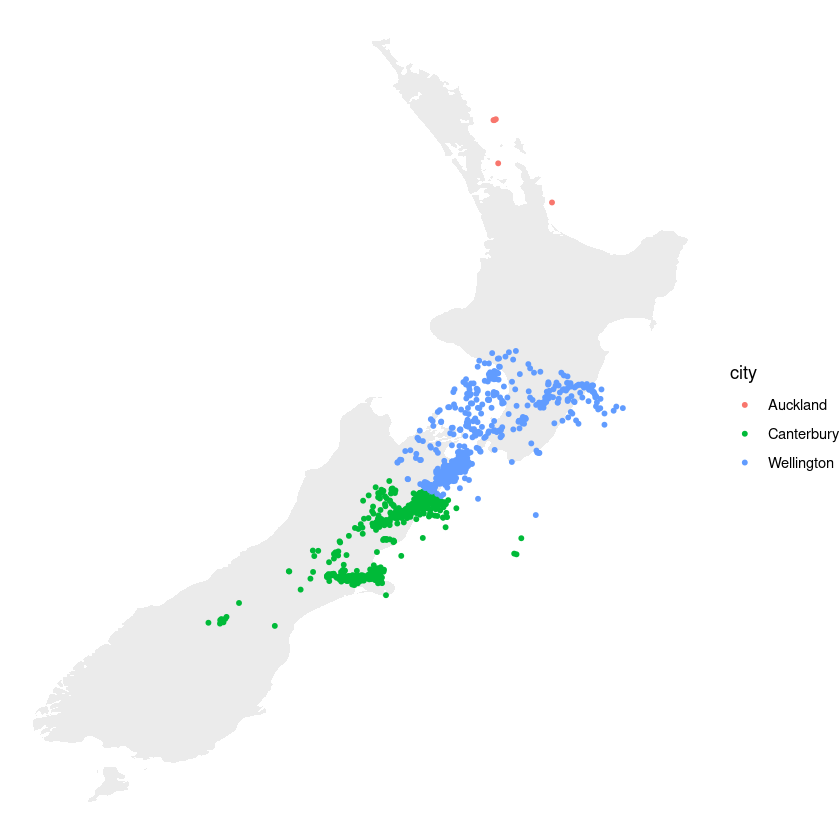

In [6]:
ggplot() +
  geom_polygon(data = NZ, aes(x=long, y = lat, group = group), fill="grey", alpha=0.3) +
  geom_point(data=nzmentalquake::earthquake_dataset, aes(x=longitude, y=latitude, col=city), size=1) +
  theme_void()

#### Earhquake map version 2:
Size by magnitude, colour by depth. Bigger the dot stronger the magnitude, the lighter the deeper.
(Dots in bigger size with darker colour have more impact)

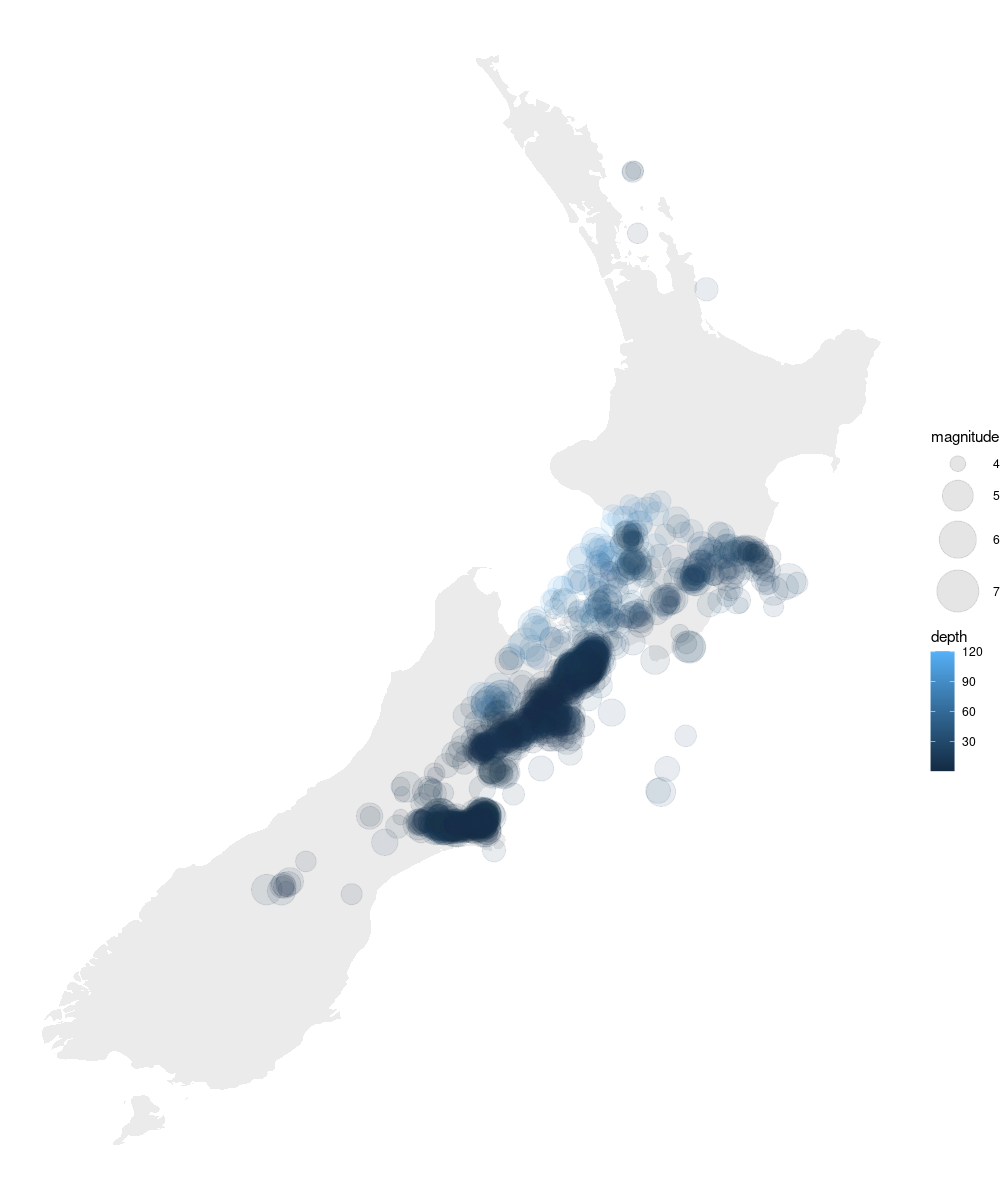

In [7]:
options(repr.plot.width = 10, repr.plot.height = 12, repr.plot.res = 100)

ggplot() +
  geom_polygon(data = NZ, aes(x=long, y = lat, group = group), fill="grey", alpha=0.3) +
  geom_point(data=nzmentalquake::earthquake_dataset, aes(x=longitude, y=latitude, col=depth, size=magnitude), alpha=0.1) +
  scale_size_continuous(range=c(5,15)) +
  theme_void()

### Plot 2: Scatter Plot

#### Joining tables

In [8]:
joined_table <- eq_summary_df %>% full_join(mh_df, by=c('city','year')) %>%
        full_join(pop_df, by=c('city','year')) %>%
        filter(sex=='Total') #%>% na.omit()
joined_table %>% head()

,X,city,year,number_of_eq,average_mag,max_mag,sex,total,Total.Pop,Pop.change
,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
1,1,Auckland,2007,1,4.100000,4.100000,Total,38441,1545100,19400
2,2,Auckland,2010,1,4.255000,4.255000,Total,41114,1600200,20300
3,3,Auckland,2019,3,4.068303,4.148209,Total,65813,1870100,29500
4,4,Canterbury,2005,5,4.302400,4.700000,Total,11000,531900,NA
5,5,Canterbury,2006,3,4.188000,4.464000,Total,10998,540000,8100
6,6,Canterbury,2007,8,4.368750,5.500000,Total,10836,547400,7400


#### Total number of mental health patients vs Number of earthquakes

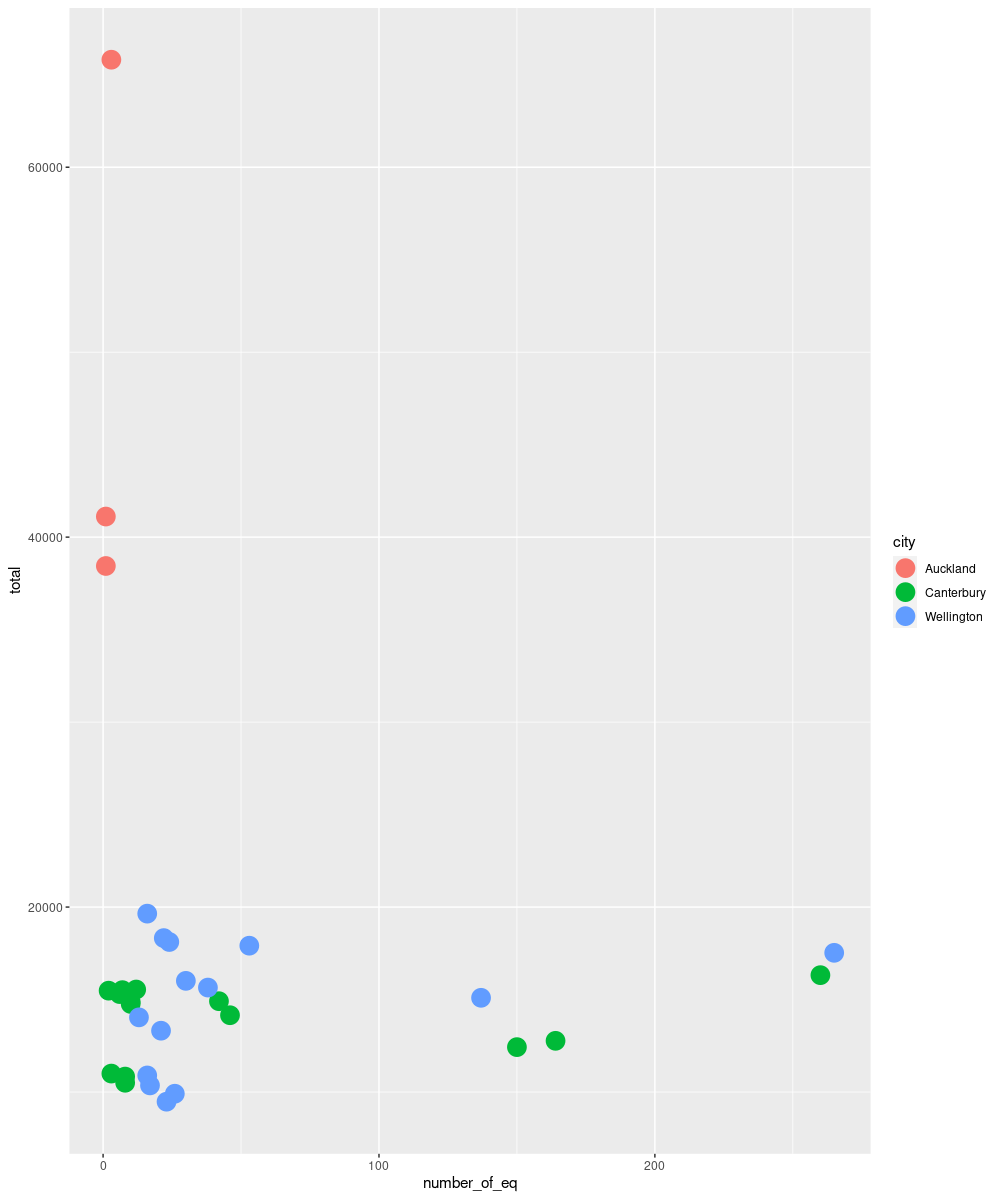

In [9]:
joined_table %>% na.omit() %>% ggplot(aes(x=number_of_eq, y=total, color=city)) + geom_point(size=6)

#### Total number of mental health patients vs Average magnitude

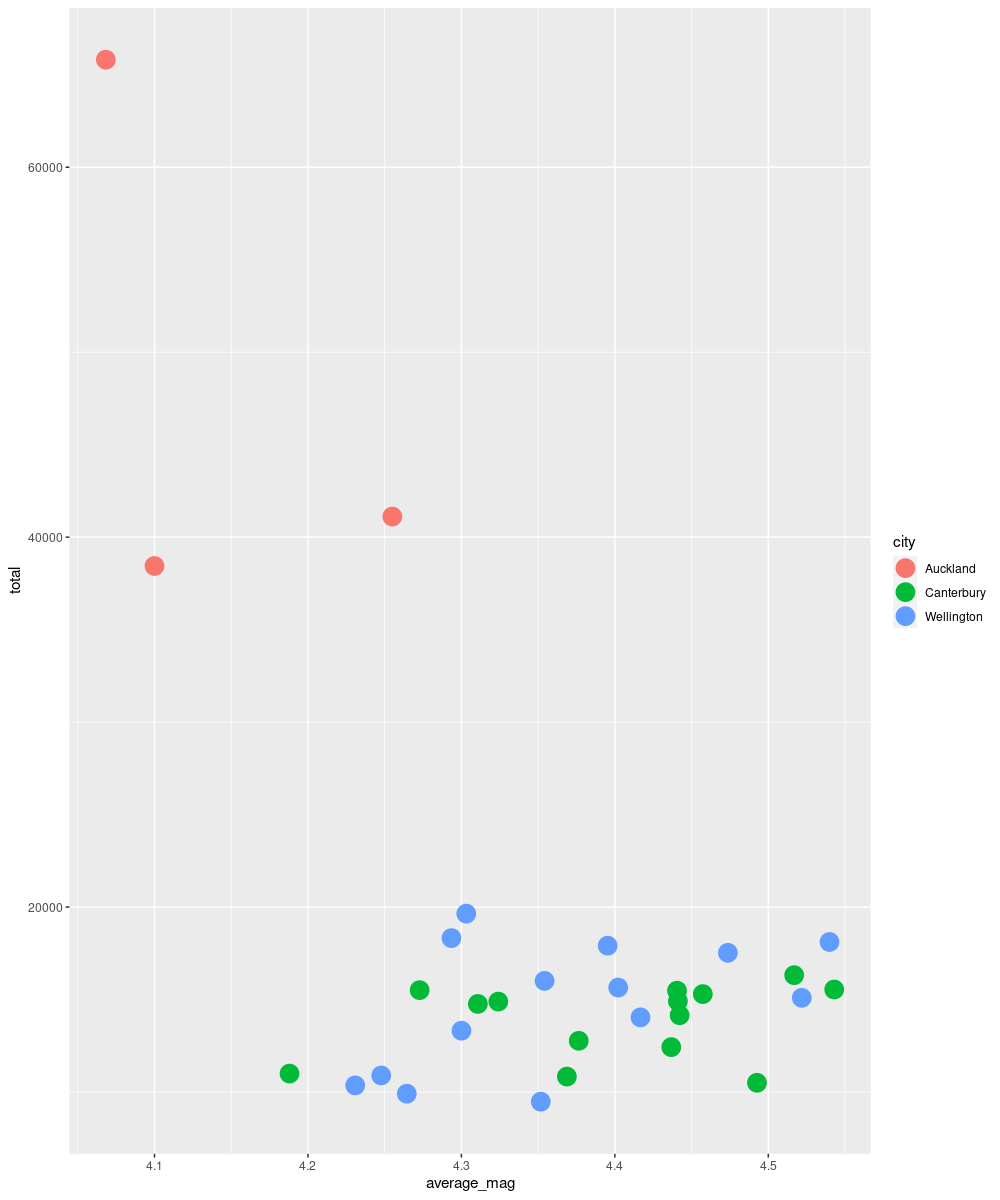

In [10]:
joined_table %>% na.omit() %>% ggplot(aes(x=average_mag, y=total, color=city)) + geom_point(size=6)

#### Total number of mental health patients vs Max magnitude

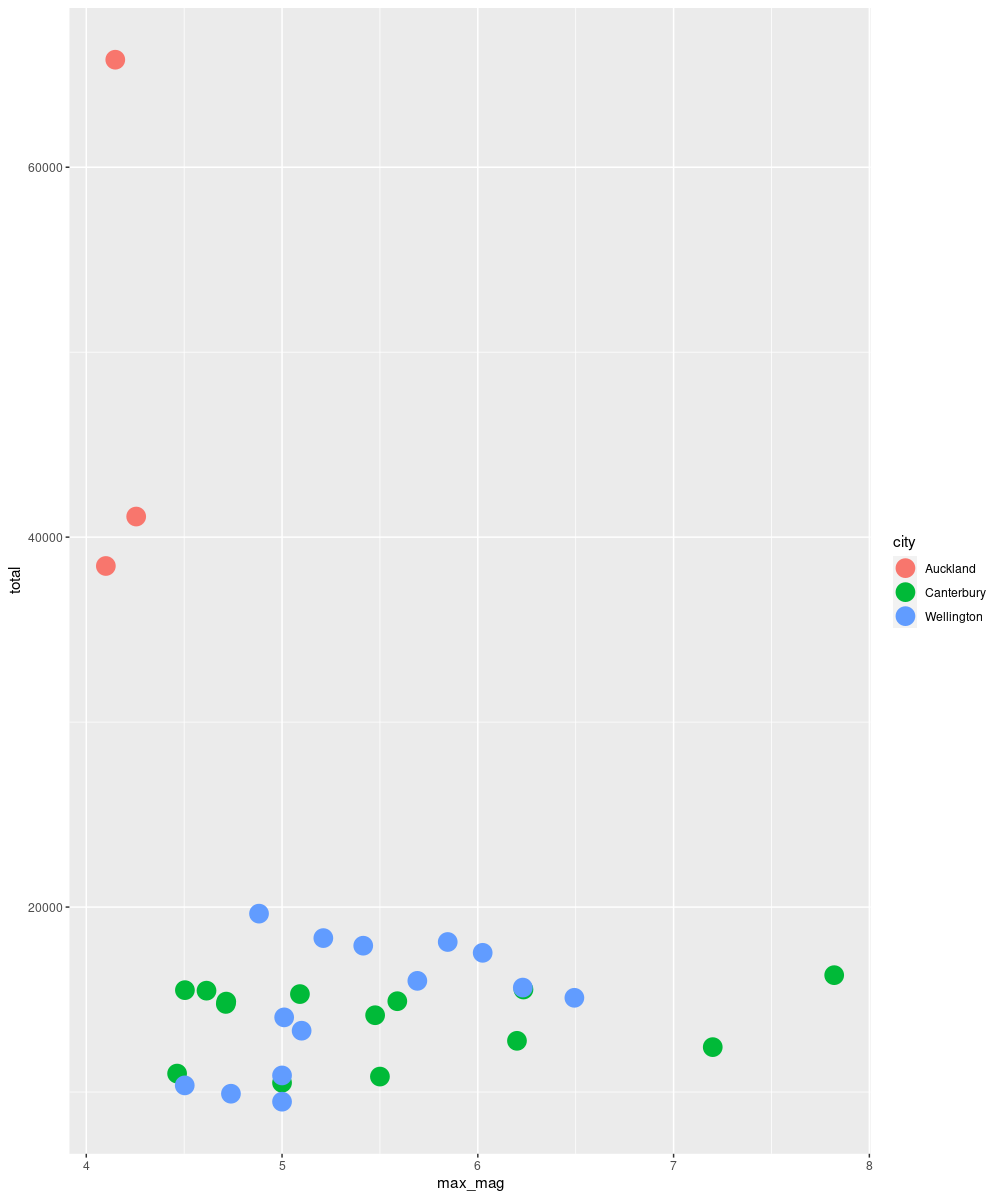

In [11]:
joined_table %>% na.omit() %>% ggplot(aes(x=max_mag, y=total, color=city)) + geom_point(size=6)

### Plot 3: Bar Graph

Warning message:
“Removed 3 rows containing missing values (geom_bar).”


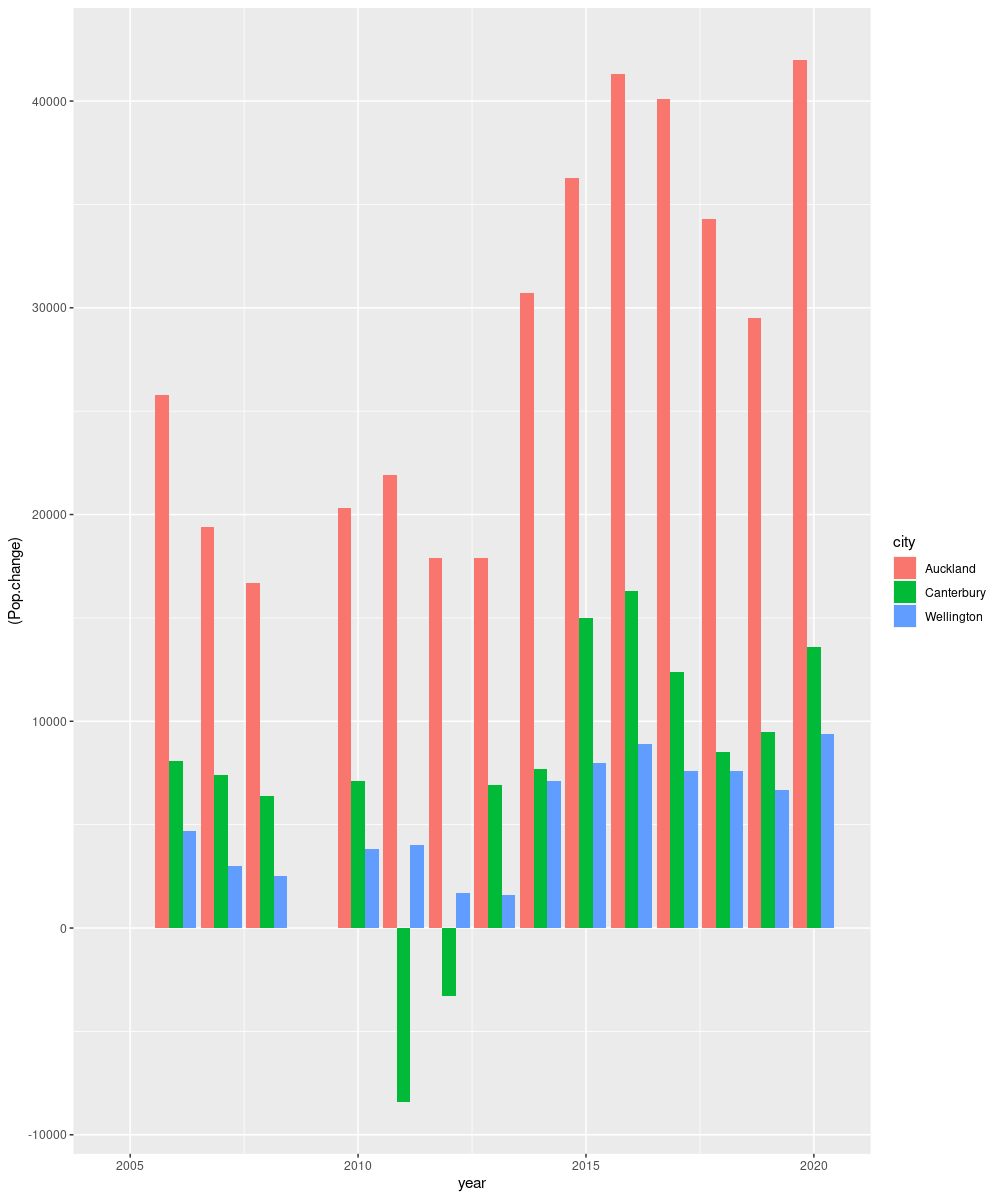

In [12]:
joined_table %>% ggplot(aes(fill=city, y=(Pop.change), x=year)) + 
    geom_bar(position="dodge", stat="identity")

### Plot 4: Time Series?

#### Line graph - Population change and number of mental health patients

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


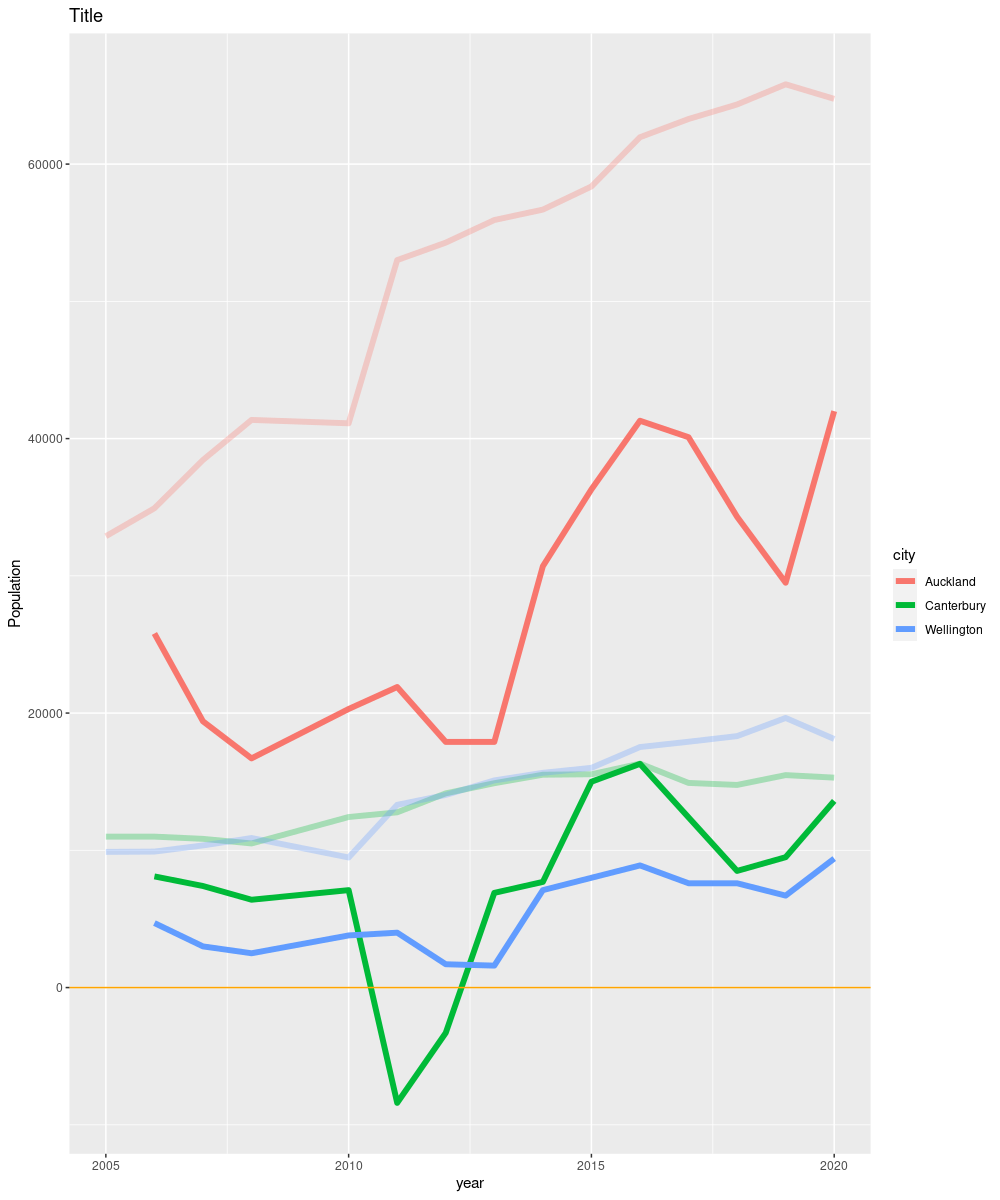

In [13]:
joined_table %>%
  ggplot( aes(x=year)) +
    geom_line(aes(y=Pop.change, group=city, color=city), size=2) +
    geom_line(aes(y=total, group=city, color=city), size=2, alpha=0.3) +
    geom_hline(yintercept=0, color="orange", size=.5) +
    ggtitle("Title") +
    ylab("Population")


In [110]:
#### Line graph - Annual max magnitude and average magnitude by city

Warning message:
“Removed 3 row(s) containing missing values (geom_path).”
Warning message:
“Removed 3 row(s) containing missing values (geom_path).”


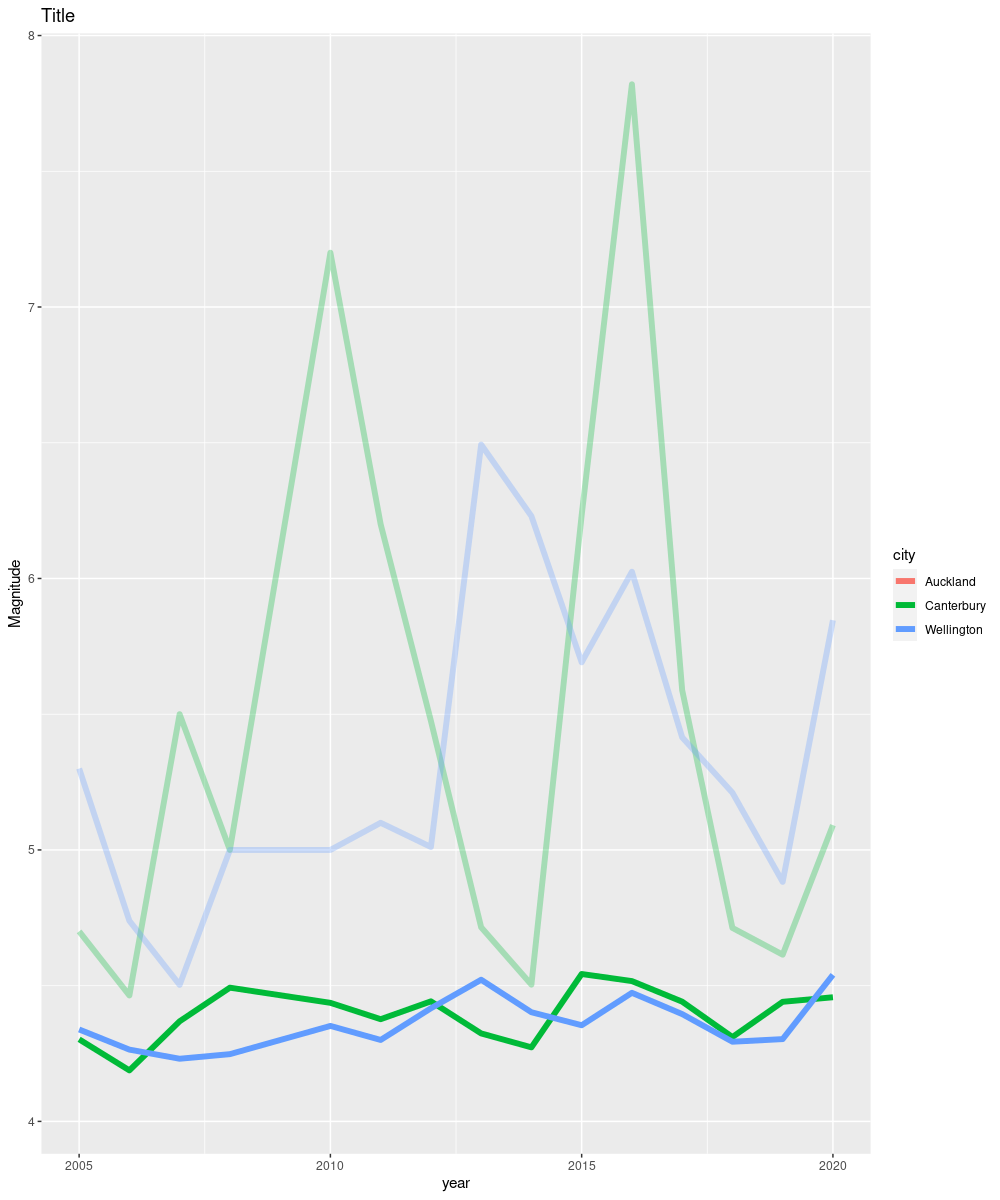

In [14]:
joined_table %>%
  ggplot( aes(x=year)) +
    geom_line(aes(y=average_mag, group=city, color=city), size=2) +
    geom_line(aes(y=max_mag, group=city, color=city), size=2, alpha=0.3) + # Maximum magnitude
    ggtitle("Title") +
    ylab("Magnitude")
